In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from fucntions import data_seq,train_seq
from sklearn.preprocessing import MinMaxScaler

In [2]:
"""
!git clone https://github.com/Han-JaeHoon/QHackathon_2024.git
%cd QHackathon_2024/
!pip install -r requirements.txt"""

'\n!git clone https://github.com/Han-JaeHoon/QHackathon_2024.git\n%cd QHackathon_2024/\n!pip install -r requirements.txt'

In [3]:
n_qu = 4
dev = qml.device('default.qubit', wires=2*n_qu)

def ansatz(params, n_qu, all_entangled = False):
    # Length of Params : 3 * num_qubit
    for i in range(n_qu):
        qml.RX(params[:, 3*i], i)
        qml.RY(params[:, 3 * i + 1], i)
        qml.RZ(params[:, 3 * i + 2], i)
    for i in range(n_qu - 1):
        qml.CNOT([i, i + 1])
    if all_entangled:
        qml.CNOT([n_qu - 1, 0])

def embedding(params, n_qu, is_first):
    for i in range(n_qu):
        qml.Hadamard(wires=i if is_first else i+n_qu)
        qml.RZ(2.0*params[:,i], wires=i if is_first else i+n_qu)

    for i in range(n_qu-1):
        qml.IsingZZ(2.0*params[:, i] ,wires = [i if is_first else i+n_qu, i+1 if is_first else i+n_qu+1])

@qml.qnode(device=dev, interface='torch')
def quantum_layer_Z(mapped_data1, mapped_data2, parameter, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu, is_first=True)
    embedding(params=mapped_data2, n_qu=n_qu, is_first=False)
    qml.Barrier()
    ansatz(params=parameter, n_qu = 2*n_qu)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qu,n_qu*2)]

@qml.qnode(device=dev, interface='torch')
def quantum_layer_prob(mapped_data1, mapped_data2, parameter, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu, is_first=True)
    embedding(params=mapped_data2, n_qu=n_qu, is_first=False)
    qml.Barrier()
    ansatz(params=parameter, n_qu = 2*n_qu)
    return [qml.expval((qml.PauliZ(i)+qml.Identity(i))/2) for i in range(n_qu,n_qu*2)]
dev = qml.device('default.qubit', wires=8)
@qml.qnode(device=dev, interface='torch')
def quantum_layer_RNN(mapped_data1,parameter,n_qu= 4):
    index = [0,1,2,3,4,5,6,7,6,5,4,3,2]
    for i,data in enumerate(mapped_data1):
        embedding(params=data, n_qu=n_qu, is_first=True,start_idx=index[i])
        qml.Barrier()
        ansatz(params=parameter, n_qu = n_qu)
        qml.Barrier()
        if len(mapped_data1)-1 == i:
            continue
        qml.measure(index[i+1],reset=True)
        qml.measure(index[i+2],reset=True)
        qml.measure(index[i+3],reset=True)
        qml.measure(index[i+4],reset=True)
        qml.Barrier()
    return qml.expval((qml.PauliZ(6)+qml.Identity(6))/2)

(<Figure size 1900x900 with 1 Axes>, <Axes: >)

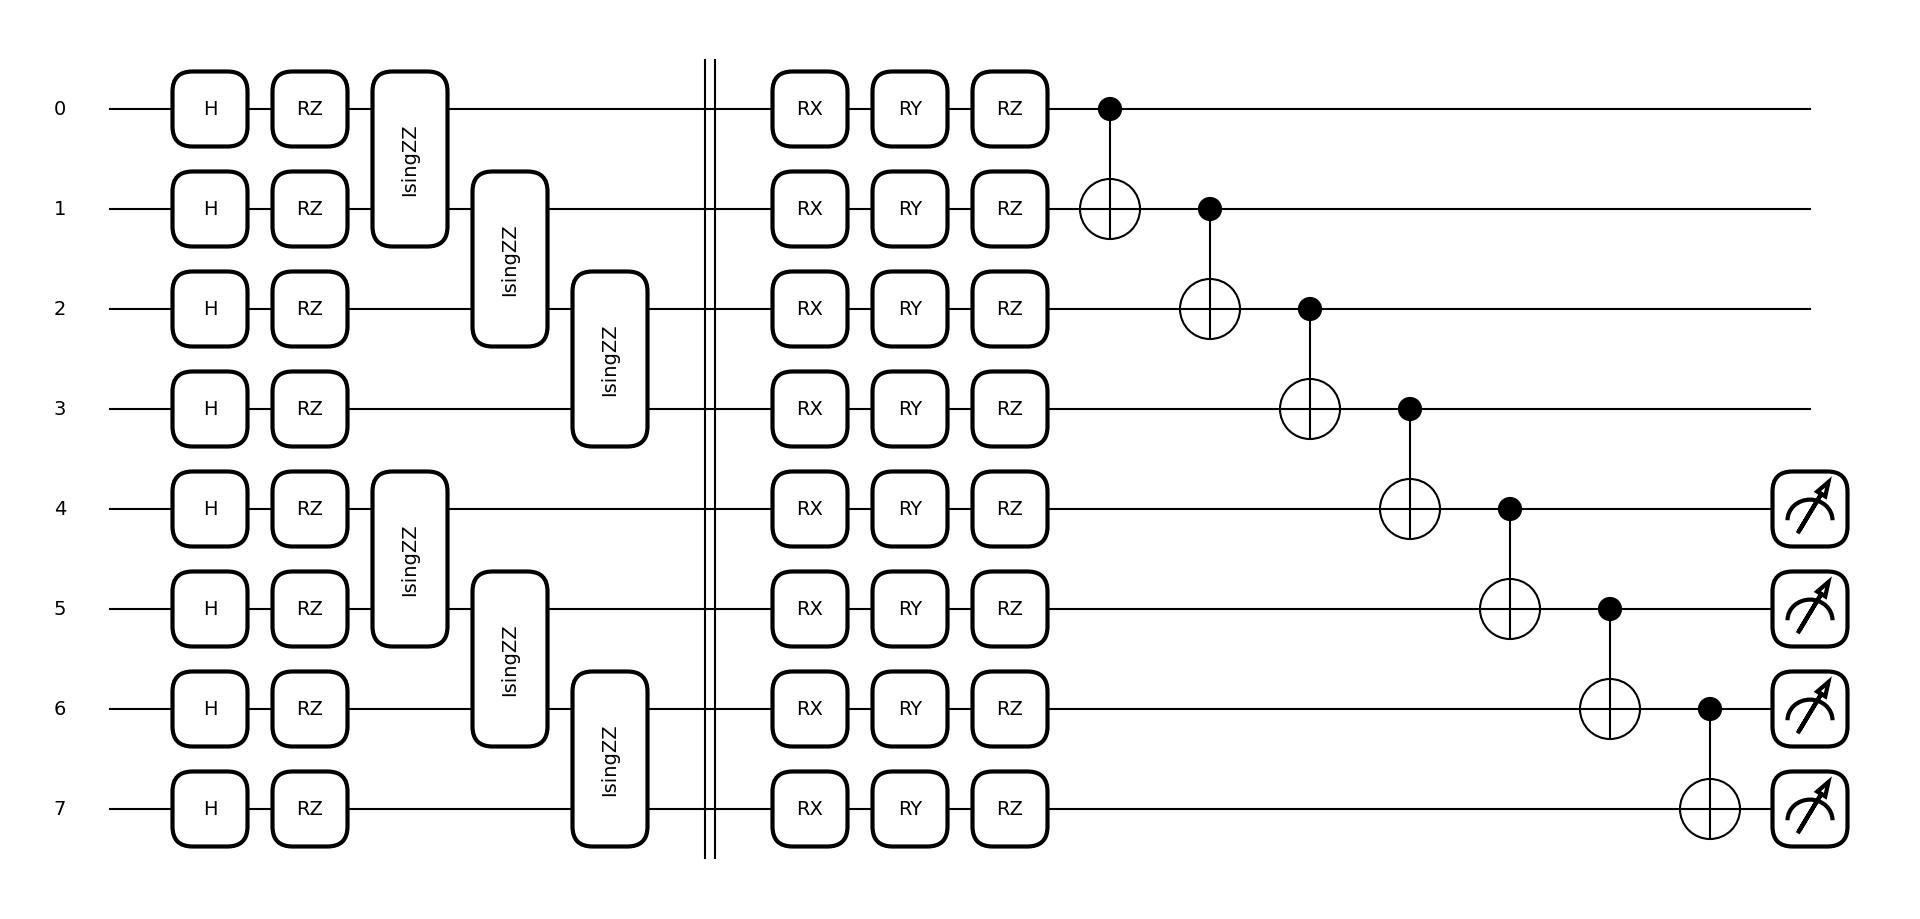

In [4]:
qml.draw_mpl(quantum_layer_prob)(torch.rand(1,2*n_qu-1), torch.rand(1,2*n_qu-1), torch.rand(1,6*n_qu), n_qu=n_qu)

In [5]:
class QGRU(nn.Module):
    def __init__(self, n_qu):
        self.n_qu = n_qu
        super(QGRU, self).__init__()
        for i in range(2):
            setattr(self,f'ql{i}', quantum_layer_prob)
        self.ql2 = quantum_layer_Z
        self.cls_layer = nn.Sequential(nn.Linear(n_qu,16), nn.ReLU(),nn.Linear(16,1)).to(torch.float32)

        self.ansatz_params_1 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_2 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_3 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)

    def nQE_layer(self, input):
        n_qu = input.shape[1]
        n_batch = input.shape[0]
        for i in range(n_qu-1):
            input = torch.cat(([input,((torch.pi-input[:,i])*(torch.pi-input[:,i+1])).reshape(n_batch,1)]),1)
        return input

    def forward(self, inputs, return_hidden_list = False):
        batch = inputs.shape[0]
        seq_len = inputs.shape[1]
        n_qu = inputs.shape[2]
        inputs = inputs.permute(1,0,2)
        h0 = torch.zeros(batch,n_qu)
        input0 = self.nQE_layer(inputs[0])
        r0 = torch.stack(self.ql0(input0, self.nQE_layer(h0), self.ansatz_params_1, n_qu),dim=1)
        z0 = torch.stack(self.ql1(input0, self.nQE_layer(h0), self.ansatz_params_2, n_qu),dim=1)
        n0 = torch.stack(self.ql2(input0, r0, self.ansatz_params_3, n_qu),dim=1)
        hidden = (1-z0)*n0+z0*h0
        if return_hidden_list:
            hidden_list = hidden
        for input in inputs[1:]:
            input = self.nQE_layer(input)
            h = hidden
            ah = self.nQE_layer(hidden)
            r = torch.stack(self.ql0(input, ah, self.ansatz_params_1, n_qu),dim=1)
            z = torch.stack(self.ql1(input, ah, self.ansatz_params_2, n_qu),dim=1)
            n = torch.stack(self.ql2(input, r, self.ansatz_params_3, n_qu),dim=1)
            hidden = (1-z)*n+z*h
            if return_hidden_list:
                hidden_list = torch.concat([hidden_list, hidden])
        if return_hidden_list:
            hidden_list = torch.reshape(hidden_list,[batch, seq_len,-1])
            return hidden_list
        return self.cls_layer(hidden.to(torch.float32))

In [6]:

import pandas as pd
n_train = 1000
df = pd.read_csv('./dataset.csv')
print(df.keys())


Index(['datetime', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc',
       'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav',
       'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')


In [36]:

import pandas as pd

# 각 지역의 데이터를 평균 내어 축소
df['T2M_avg'] = df[['T2M_toc', 'T2M_san', 'T2M_dav']].mean(axis=1)
df['QV2M_avg'] = df[['QV2M_toc', 'QV2M_san', 'QV2M_dav']].mean(axis=1)
df['TQL_avg'] = df[['TQL_toc', 'TQL_san', 'TQL_dav']].mean(axis=1)
df['W2M_avg'] = df[['W2M_toc', 'W2M_san', 'W2M_dav']].mean(axis=1)

# 필요한 컬럼만 선택하여 새로운 데이터 프레임 생성
avg_df = df[['datetime', 'nat_demand', 'T2M_avg', 'QV2M_avg', 'TQL_avg', 'W2M_avg', 'Holiday_ID', 'holiday', 'school']]
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
fit_data = scaler.fit_transform(avg_df[['nat_demand']])
scaled_features = avg_df[['nat_demand','T2M_avg', 'QV2M_avg', 'TQL_avg', 'W2M_avg']].to_numpy()

In [34]:
scaler.fit_transform(avg_df[['nat_demand']])

array([[0.53013   ],
       [0.49529149],
       [0.4881604 ],
       ...,
       [0.59674299],
       [0.57281998],
       [0.55601703]])

In [47]:
np.squeeze(fit_data)

array([0.53013   , 0.49529149, 0.4881604 , ..., 0.59674299, 0.57281998,
       0.55601703])

In [43]:
scaled_features[:,0].shape

(48048,)

In [48]:
scaled_features[:,0] = np.squeeze(fit_data)

In [49]:
scaled_features

array([[5.30130003e-01, 2.40032796e+01, 1.74701197e-02, 3.80431798e-02,
        1.25145475e+01],
       [4.95291490e-01, 2.39591512e+01, 1.74758220e-02, 3.51306596e-02,
        1.28069776e+01],
       [4.88160403e-01, 2.39372803e+01, 1.74861213e-02, 3.18811729e-02,
        1.30670061e+01],
       ...,
       [5.96742987e-01, 2.53409465e+01, 1.94311840e-02, 1.18347169e-01,
        5.15318337e+00],
       [5.72819976e-01, 2.52424866e+01, 1.94083983e-02, 1.08337405e-01,
        5.39518968e+00],
       [5.56017032e-01, 2.51461629e+01, 1.93754290e-02, 1.08917238e-01,
        5.42365813e+00]])

In [52]:

label_list = [5+5*i for i in range(500)]
label = torch.tensor(scaled_features[:,0][label_list],dtype=torch.float32)
label = torch.unsqueeze(label,dim=1)
train_data = scaled_features[:,1:5][:2500]
train_data = torch.reshape(torch.tensor(train_data,dtype=torch.float32),[-1,5,4])

In [53]:

datas = data_seq(train_data,label)
train_loader,test_loader = datas.split_data(batch_size=32)
data_dict = {'train':train_loader,'test':test_loader}

In [54]:
import pickle
with open('train_data_NQE.pkl','wb') as file:
    pickle.dump(data_dict ,file)
    #data_dict = pickle.load(file)

train_loader,test_loader = data_dict['train'],data_dict['test']

In [12]:
from RNN_block import RNN_block
from kan import KAN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0),self.hidden_size)  # 초기 은닉 상태
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 사용
        return out

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs1,inputs2, weights1,weights2):
    block = RNN_block(4)
    block.embedding(inputs1)
    block.ansatz(weights1)
    block.embedding(inputs2)
    block.ansatz(weights2)
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

def quantum_layer(inputs1,inputs2, weights1,weights2):
    return quantum_circuit(inputs1,inputs2, weights1,weights2)

def generate_tensor(seed, size):
    """
    주어진 시드와 크기에 맞게 torch.Tensor를 생성합니다.

    Args:
        seed (int): 시드 값
        size (tuple): 생성할 텐서의 크기

    Returns:
        torch.Tensor: 생성된 텐서
    """
    torch.manual_seed(seed)
    return torch.randn(size)
class RNN_layer(nn.Module):
    def __init__(self,input_size,output_size,num_layers):
        """_RNN layer 만든거_

        Args:
            input_size (_int_): _input feature의 개수_
            output_size (_int_): _output feature의 개수_
            num_layers (_int_): _필요한 RNN layer 수_
        """
        super(RNN_layer, self).__init__()
        self.linear = KAN([input_size,input_size*2-1],grid=1)
        self.input_size = input_size
        self.output_size = output_size
        self.num_layer = num_layers
        self.cls_layer = nn.Sequential(nn.Linear(4,16),nn.ReLU(),nn.Linear(16,1))
        ## QNE 수행할 Linear layer
        for i in range(num_layers):
            setattr(self,f'QNE_layer_{i}',KAN([input_size,2*input_size+1,input_size*2-1],grid=1))

        ## Ansatz parameter
        self.ansatz_params_1 = nn.Parameter(torch.rand([24],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_2 = nn.Parameter(torch.rand([24],dtype = torch.float32),requires_grad=True)
        self.rnn_layer = quantum_layer


    def forward(self,inputs,return_hidden_list = False):
        """_summary_

        Args:
            inputs (_torch tensor_): _(batch,seq_len,feature_size)_
        """
        index = 0

        batch = inputs.shape[0]
        seq_len = inputs.shape[1]
        initial_t = generate_tensor(30,[inputs.shape[0],inputs.shape[2]*2-1]).float()
        inputs = inputs.permute(1, 0, 2)
        ## inputs  = (seq_len,batch,feature_size)
        input = getattr(self,f'QNE_layer_{0}')(inputs[0])
        index+=1
        hidden = torch.stack(self.rnn_layer(initial_t,input,self.ansatz_params_1,self.ansatz_params_2),dim=1).float()
        hidden = hidden.to(torch.float32)
        if return_hidden_list:
            hidden_list = hidden
        for input in inputs[1:]:
            input = getattr(self,f'QNE_layer_{0}')(input)
            index+=1
            hidden = self.linear(hidden)
            hidden = torch.stack(self.rnn_layer(hidden,input,self.ansatz_params_1,self.ansatz_params_2),dim=1).float()
            hidden = hidden.to(torch.float32)
            if return_hidden_list:
                hidden_list = torch.concat([hidden_list,hidden])
        if return_hidden_list:
            hidden_list = torch.reshape(hidden_list,[batch,seq_len,-1])
            return hidden_list
        return self.cls_layer(hidden)
class QRNN(nn.Module):
    def __init__(self):
        super(QRNN, self).__init__()
        self.rnn_layer = quantum_layer_RNN
        self.Q_params = nn.Parameter(torch.rand([1,24],dtype = torch.float32),requires_grad=True)
        self.linear = KAN([1,2,1],grid = 1)
        for i in range(5):
            setattr(self,f'KAN_layer_{i}',KAN([4,7],grid=1))

    def forward(self,input):
        input = input.permute(1,0,2)
        full_list = []
        for index,data in enumerate(input):
            part = getattr(self,f'KAN_layer_{index}')(data)
            full_list.append(part)
        input = torch.stack(full_list,dim=0)
        
        output = self.rnn_layer(input,self.Q_params).float()
        output = torch.unsqueeze(output,dim=1)
        return self.linear(output)
    
dev = qml.device('default.qubit', wires=4)
@qml.qnode(device=dev, interface='torch')
def quantum_layer_RNN(mapped_data1,parameter,n_qu= 4):
    for data in mapped_data1:
        embedding(params=data, n_qu=n_qu, is_first=True)
        qml.Barrier()
        ansatz(params=parameter, n_qu = n_qu//2)
        qml.Barrier()

    return qml.expval((qml.PauliZ(0)+qml.Identity(0))/2)

In [35]:
import torch.optim as optim
#model = QGRU(4).to(torch.float32)
#model = RNN_layer(4,1,5)
model = RNNModel(4,32,1)
#model = QRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)


In [36]:
#data_corpus = data_seq(x_train.float(),y_train.float())
#train_loader,test_loader = data_corpus.split_data()
train_corpus = train_seq(model,train_loader,test_loader)

In [37]:
def get_data(model,train_loader,test_loader):
    pred_list = []
    train_label_list = []
    test_pred_list = []
    test_label_list = []
    for data,label in train_loader:
        pred = model(data)
        pred_list.append(pred.detach().numpy())
        train_label_list.append(label.numpy())
    for data,label in test_loader:
        pred = model(data)
        test_pred_list.append(pred.detach().numpy())
        test_label_list.append(label.numpy())

    return list(np.concatenate(pred_list).reshape(-1)),list(np.concatenate(train_label_list).reshape(-1)),list(np.concatenate(test_pred_list).reshape(-1)),list(np.concatenate(test_label_list).reshape(-1))

In [38]:
train_corpus.train(500,optimizer,criterion)

epoch : 1 loss :6.876282215118408 loss_test = 3.047247886657715
epoch : 2 loss :1.3198142051696777 loss_test = 0.574867308139801
epoch : 3 loss :0.4954655170440674 loss_test = 0.5642114877700806
epoch : 4 loss :0.5239617824554443 loss_test = 0.532590389251709
epoch : 5 loss :0.46303650736808777 loss_test = 0.529356062412262
epoch : 6 loss :0.45198607444763184 loss_test = 0.5317510962486267
epoch : 7 loss :0.4396456480026245 loss_test = 0.5054821968078613
epoch : 8 loss :0.4197269082069397 loss_test = 0.49144211411476135
epoch : 9 loss :0.39338427782058716 loss_test = 0.46081915497779846
epoch : 10 loss :0.36551254987716675 loss_test = 0.4389687478542328
epoch : 11 loss :0.33061882853507996 loss_test = 0.41241854429244995
epoch : 12 loss :0.2990676760673523 loss_test = 0.3779202401638031
epoch : 13 loss :0.2819170355796814 loss_test = 0.3900122046470642
epoch : 14 loss :0.2699432373046875 loss_test = 0.356806218624115
epoch : 15 loss :0.2672443091869354 loss_test = 0.35351845622062683
e

In [39]:
train_loss_list, test_loss_list = train_corpus.train_loss_list ,train_corpus.test_loss_list
pred_list,train_label_list,test_pred_list,validation_label = get_data(model,train_loader,test_loader)

In [40]:
import pandas as pd


# 각 리스트의 길이 확인
lengths = [len(train_loss_list), len(test_loss_list), len(pred_list), len(train_label_list), len(test_pred_list), len(validation_label)]
max_length = max(lengths)

# 리스트의 길이를 최대 길이로 맞추기 (None으로 패딩)
def pad_list(lst, max_length):
    return lst + [None] * (max_length - len(lst))

train_loss_list = pad_list(train_loss_list, max_length)
test_loss_list = pad_list(test_loss_list, max_length)
pred_list = pad_list(pred_list, max_length)
train_label_list = pad_list(train_label_list, max_length)
test_pred_list = pad_list(test_pred_list, max_length)
validation_label = pad_list(validation_label, max_length)

# 데이터 프레임 생성
data_set = pd.DataFrame({
    'train_loss': train_loss_list,
    'test_loss': test_loss_list,
    'train_predict': pred_list,
    'train_label': train_label_list,
    'validation_predict': test_pred_list,
    'validation_label': validation_label
})

data_set.to_csv('./result_data/cRNN_fixed_data.csv',index=False)

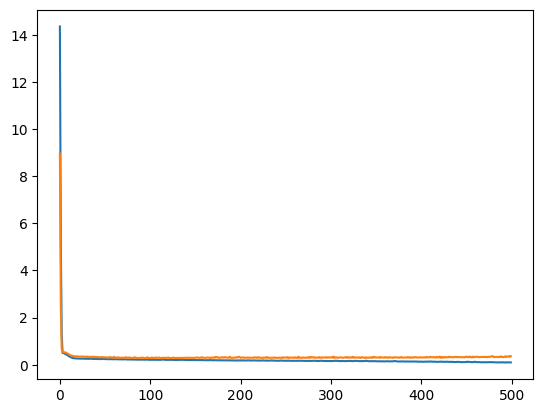

In [298]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list)
plt.plot(test_loss_list)

In [299]:
def decoding(input,max_value):
  return (np.max(df['nat_demand'])-np.min(df['nat_demand']))/max_value*input+np.min(df['nat_demand'])

for feature,label in test_loader:
    pred = decoding(model(feature),2*3.14)
    true = decoding(label,2*3.14)
    print(nn.MSELoss()(true,pred))
    break

tensor(24212.1953, grad_fn=<MseLossBackward0>)


In [300]:
def decoding(input,max_value):
  return (np.max(df['nat_demand'])-np.min(df['nat_demand']))/max_value*input+np.min(df['nat_demand'])

for feature,label in test_loader:
    pred = decoding(model(feature),2*3.14)
    true = decoding(label,2*3.14)
    print(nn.MSELoss()(true,pred))
    break

tensor(24212.1953, grad_fn=<MseLossBackward0>)


In [ ]:
y_train = torch.tensor(df['nat_demand'].to_numpy()[:n_train]).to(torch.float).reshape(1,50,1)
print(y_train.shape)
x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:n_train]).to(torch.float)
print(x_train.shape)
xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T.reshape(1,50,4)
#y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


import torch.optim as optim
# Define the training loop



def train_layer(inputs,targets,model):
    # Parameters
    num_epochs = 500
    learning_rate = 0.2


    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Dummy data for training

    # Training loop
    for epoch in range(num_epochs):

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.to(torch.float32)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.Size([1, 50, 1])
torch.Size([50, 12])


In [ ]:
model = QGRU(4).to(torch.float32)

In [ ]:
train_layer(xs.to(torch.float32), y_train.to(torch.float32), model)

/Users/jeon-yuseong/miniconda3/envs/penny_torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 50, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/500], Loss: 1076137.3750
Epoch [2/500], Loss: 1075223.2500
Epoch [3/500], Loss: 1074069.7500
Epoch [4/500], Loss: 1072090.7500
Epoch [5/500], Loss: 1068951.2500
Epoch [6/500], Loss: 1064471.5000
Epoch [7/500], Loss: 1058890.5000
Epoch [8/500], Loss: 1053203.7500
Epoch [9/500], Loss: 1045896.8125
Epoch [10/500], Loss: 1037101.2500
Epoch [11/500], Loss: 1027466.5000
Epoch [12/500], Loss: 1016006.6250
Epoch [13/500], Loss: 1002249.1250
Epoch [14/500], Loss: 986216.0000
Epoch [15/500], Loss: 968299.8125
Epoch [16/500], Loss: 948492.0000
Epoch [17/500], Loss: 928357.6875
Epoch [18/500], Loss: 907706.5000
Epoch [19/500], Loss: 885891.9375
Epoch [20/500], Loss: 862132.6250
Epoch [21/500], Loss: 836294.3750
Epoch [22/500], Loss: 808483.5000
Epoch [23/500], Loss: 779296.9375
Epoch [24/500], Loss: 749222.0625
Epoch [25/500], Loss: 718772.8125
Epoch [26/500], Loss: 687639.1875
Epoch [27/500], Loss: 654609.3750
Epoch [28/500], Loss: 620000.3750
Epoch [29/500], Loss: 584305.6250
Epoch [30/

KeyboardInterrupt: 